exam the similarity metric difference
1. representation cosine
2. EL2N
3. Grad Norm

In [1]:
import os, sys
import json
import torch
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from pynndescent import NNDescent
from scipy import stats

sys.path.append("..")
from singleVis.SingleVisualizationModel import VisModel
from singleVis.data import NormalDataProvider

In [2]:
VIS_METHOD = "DVI" # DeepVisualInsight
CONTENT_PATH = "/home/xianglin/projects/DVI_data/resnet18_fmnist"
GPU_ID = "0"

In [3]:
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

In [4]:
SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

In [5]:
import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

In [6]:
# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, classes=CLASSES, epoch_name="Epoch", verbose=1)
if PREPROCESS:
    data_provider._meta_data()
    if B_N_EPOCHS >0:
        data_provider._estimate_boundary(LEN//10, l_bound=L_BOUND)

Finish initialization...


In [7]:
def nn(train_data):
    # number of trees in random projection forest
    n_trees = min(64, 5 + int(round((train_data.shape[0]) ** 0.5 / 20.0)))
    # max number of nearest neighbor iters to perform
    n_iters = max(5, int(round(np.log2(train_data.shape[0]))))
    # distance metric
    metric = "cosine"
    # get nearest neighbors
    nnd = NNDescent(
        train_data,
        n_neighbors=2,
        metric=metric,
        n_trees=n_trees,
        n_iters=n_iters,
        max_candidates=60,
        verbose=False
    )
    knn_indices, _ = nnd.neighbor_graph
    return knn_indices[:, 1]

In [8]:
# compute EL2N
prev_e = 1
next_e = 20
prev_data = data_provider.train_representation(prev_e)
next_data = data_provider.train_representation(next_e)
train_labels = data_provider.train_labels(prev_e)
prev_pw = data_provider.get_pred(next_e, prev_data)
next_pw = data_provider.get_pred(next_e, next_data)
y = np.eye(np.max(train_labels)+1)[train_labels]

100%|██████████| 300/300 [00:00<00:00, 8663.05it/s]


In [9]:
next_el2n = next_pw-y
indices = nn(next_el2n)
closest_el2n = next_el2n[indices]
print("Closest sample in spatial (el2n)")
closest_el2n_sim = np.array([distance.cosine(closest_el2n[i], next_el2n[i]) for i in range(len(prev_data))])
# closest_el2n_sim = np.array([distance.euclidean(closest_el2n[i], next_el2n[i]) for i in range(len(prev_data))])
closest_el2n_sim.mean(), closest_el2n_sim.max(), closest_el2n_sim.min(), np.sum(closest_el2n_sim<closest_el2n_sim.mean())

Closest sample in spatial (el2n)


(0.0015935003091235537, 0.27605884758999644, 2.3590392961292395e-07, 48088)

In [10]:
indices = nn(next_data)
closest_repr = next_data[indices]
print("Closest sample in spatial (repr)")
closest_repr_sim = np.array([distance.cosine(closest_repr[i], next_data[i]) for i in range(len(prev_data))])
# closest_repr_sim_eu = np.array([distance.euclidean(closest_repr[i], next_data[i]) for i in range(len(prev_data))])
closest_repr_sim.mean(), closest_repr_sim.max(), closest_repr_sim.min(), np.sum(closest_repr_sim<closest_repr_sim.mean())

Closest sample in spatial (repr)


(0.009428476477309267, 0.20775940969782503, 2.5229753518596354e-06, 41043)

In [11]:
stats.spearmanr(closest_repr_sim, closest_el2n_sim)

SpearmanrResult(correlation=0.912433547374783, pvalue=0.0)

In [14]:
prev_el2n = prev_pw-y
next_el2n = next_pw-y
print("Temporal EL2N")
el2n_sim = np.array([distance.cosine(prev_el2n[i], next_el2n[i]) for i in range(len(prev_data))])
el2n_sim.mean(), el2n_sim.max(), el2n_sim.min(), np.sum(el2n_sim<el2n_sim.mean())

Temporal EL2N


(0.17452833456570768, 1.819032124194774, 0.0035188219099987483, 39718)

In [17]:
print("Temporal repr")
repr_sim = np.array([distance.cosine(prev_data[i], next_data[i]) for i in range(len(prev_data))])
repr_sim_eu = np.array([distance.euclidean(prev_data[i], next_data[i]) for i in range(len(prev_data))])
repr_sim.mean(), repr_sim.max(), repr_sim.min(), np.sum(repr_sim<repr_sim.mean())

Temporal repr


(0.4391693970449143, 0.7961366576427347, 0.24475687000959534, 32313)

In [18]:
stats.spearmanr(repr_sim, el2n_sim), stats.spearmanr(repr_sim_eu, el2n_sim)

(SpearmanrResult(correlation=0.8296277051350633, pvalue=0.0),
 SpearmanrResult(correlation=-0.24715577499998778, pvalue=0.0))

In [12]:
def normalize_data(train_data):
    train_max = train_data.max(axis=0)
    train_min = train_data.min(axis=0)
    train_data = (train_data - train_max)/(train_max-train_min)
    return train_data

In [13]:
norm_prev_data = normalize_data(prev_data)
norm_next_data = normalize_data(next_data)

In [22]:
spatial_sim = np.array([distance.cosine(prev_data[i], next_data[i]) for i in range(len(prev_data))])
norm_spatial_sim = np.array([distance.cosine(norm_prev_data[i], next_data[i]) for i in range(len(prev_data))])
spatial_sim.mean(), spatial_sim.min(), spatial_sim.max(),norm_spatial_sim.mean(), norm_spatial_sim.min(), norm_spatial_sim.max()

(0.4391693970449143,
 0.24475687000959534,
 0.7961366576427347,
 1.4239227826200804,
 1.271736745293891,
 1.7340846400093302)

In [23]:
stats.spearmanr(spatial_sim, norm_spatial_sim)

SpearmanrResult(correlation=0.5018379568282328, pvalue=0.0)

In [24]:
norm_closest_repr = norm_next_data[indices]
spatial_repr_sim = np.array([distance.cosine(closest_repr[i], next_data[i]) for i in range(len(prev_data))])
norm_spatial_repr_sim = np.array([distance.cosine(norm_closest_repr[i], norm_next_data[i]) for i in range(len(prev_data))])
spatial_repr_sim.mean(), spatial_repr_sim.max(), spatial_repr_sim.min(), norm_spatial_repr_sim.mean(), norm_spatial_repr_sim.max(), norm_spatial_repr_sim.min()

(0.009428476477309267,
 0.20775940969782503,
 2.5229753518596354e-06,
 0.0007488045515802833,
 0.010259779776457867,
 2.2740853933278515e-07)

In [25]:
stats.spearmanr(spatial_repr_sim, norm_spatial_repr_sim)

SpearmanrResult(correlation=0.9534619224490111, pvalue=0.0)

# how many temporal points to reserve?

In [42]:
prev_e = 1
next_e = 2
selected = np.random.choice(60000, 100, replace=False)
prev_data = data_provider.train_representation(prev_e)[selected]
# prev_data = data_provider.train_representation(prev_e)
next_data = data_provider.train_representation(next_e)

In [43]:
n_neighbors = 1
# cosine distance
high_neigh = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
high_neigh.fit(prev_data)
fitting_data = np.concatenate((next_data, prev_data), axis=0)
knn_dists, knn_indices = high_neigh.kneighbors(next_data, n_neighbors=n_neighbors, return_distance=True)

(0.0, 0.6)

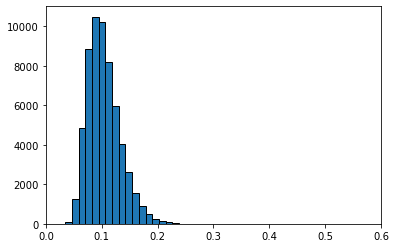

In [41]:
import matplotlib.pyplot as plt
# Create histogram
plt.clf()
plt.hist(knn_dists.squeeze(), bins=20, edgecolor='black')
plt.xlim(0, 0.6)

(0.0, 0.6)

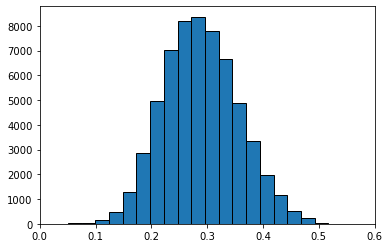

In [44]:
plt.clf()
plt.hist(knn_dists.squeeze(), bins=20, edgecolor='black')
plt.xlim(0,0.6)